# Import Packages

In [1]:
from scipy.optimize import *
from scipy.integrate import *
from numpy import *
from simple_pid import PID
import matplotlib.pyplot as plt

# Unit Conversions

In [2]:
def gal2L(L):
    
    return L*3.78541 # gallon to litre conversion

def C2K(T): # Celcius to kelvin conversion function
    
    return T + 273.15

# Parameters
## Input Parameters for Vessel

In [3]:
XH2O2 = 0.3 # Starting hydrogen peroxide strength (%w/w)

mR = 304 # Starting reactor charge (kg)

T0 = 25 # Initial temperature (C)

R = 8.3145 # Ideal gas constant (L*kPa/mol*K)

MH2O = 18.01528 # Molecular weight water (g/mol)
MH2O2 = 34.0147 # Molecular weight hydrogen peroxide (g/mol)
MO2 = 31.998 # Molecular weight oxygen (g/mol)

P0 = 101.325 # Initial pressure in headspace (kPa)

## Reactor Parameters and Geometry

In [4]:
VR = gal2L(100) # Reactor volume (gal)

Urx = 450 # Reactor heat treansfer coefficient (J/(s*m**2*K))

AR = 1.5 # Reactor aspect ratio (h/D)

Dv = 2*((VR*0.001)/(2*math.pi*AR))**(1/3) # Vessel diameter (m)

hv = Dv*AR # Vessel height (m)

In [5]:
def Awet(VL, Dv): # Calculated heat transfer area for reactor with volume fill VL (L)
    
    hwet = (VL*0.001)/(math.pi*(Dv/2)**2) # Wetted height on reactor wall (m)
    
    return math.pi*(Dv/2)**2 + 2*math.pi*(Dv/2)*hwet # Returned as m**2

## Reaction Kinetics

In [6]:
dHrxnL = -98300/MH2O2 # Heat of reaction for hydrogen peroxide decomposition in liquid phase (J/g)

kf = 3000 # Contamination coefficient

def krxn(T, kf):
    
    Aarhn = 135000 # Arrhenius coefficient/Pre-exponential factor (1/s)

    Ea = 10357 # Activation energy (J/mol)
    
    return Aarhn*kf*exp(-Ea/C2K(T))

## Reactor Vent System Parameters

In [7]:
D_RD = 12 # (in)

D_BPR = 0.5 # (in)

Cv_BPR_max = 5.5

Kd_RD = 0.67

P_RD = 1000 # (kPa)

P_BPR = 200 # (kPa)

P_discharge = 101.325 # (kPa)

def A_relief(D): # Input D in (in)
    
    return math.pi*((D*0.0254)**2)/4 # (m**2)

## Critical Flow Pressure

In [8]:
def k_ratio(T, yH2O, yH2O2, yO2):
    
    R = 8.3145 # Ideal gas constant (J/mol*K)
    
    MH2O = 18.01528 # Molecular weight water (g/mol)
    MH2O2 = 34.0147 # Molecular weight hydrogen peroxide (g/mol)
    MO2 = 31.998 # Molecular weight oxygen (g/mol)
    
    [CpH2OG, CpH2O2G, CpO2G] = CpGas(T)
    
    CpG = yH2O*CpH2OG*MH2O + yH2O2*CpH2O2G*MH2O2 + yO2*CpO2G*MO2 # Average vapour constant pressure heat capacity (J/(mol*K))
    
    CvG = CpG - R
    
    return CpG/CvG

def P_crit(P, T, yH2O, yH2O2, yO2):
    
    k = k_ratio(T, yH2O, yH2O2, yO2)
    
    return (2/(k+1))**(k/(k-1))*P # (kPa)

## Determine venting flow regime

In [9]:
def voidfrac(z, jgx, Ux, flag):
    
    C0 = 1.5
    
    F = empty(1)
    if flag == 1: # churn-turbulent
        F[0] = ((z[0]*((1 - z[0])**2))/((1 - z[0]**3)*(1 - C0*z[0]))) - (jgx/Ux)
    else: # bubbly
        F[0] = ((jgx/Ux)/(2 + C0*(jgx/Ux))) - z[0]
    
    return F
    
def two_phase(T, P_discharge, D_RD, Dv, Kd_RD, data, flag):
    
    [xH2O, xH2O2, xO2, yH2O, yH2O2, yO2, nL, nG, P, PH2O, PH2O2, PO2, VL, VG, ZO2] = data
    
    MH2O = 18.01528 # Molecular weight water (g/mol)
    MH2O2 = 34.0147 # Molecular weight hydrogen peroxide (g/mol)
    MO2 = 31.998 # Molecular weight oxygen (g/mol)
    
    R = 8.3145 # Ideal gas constant (J/mol*K)
    g = 9.81 # acceleration due to gracity (m/s**2)
    
    ntotal = nL + nG
    
    sigma = surface_tension(T) # (N/m)
    
    [CpH2OG, CpH2O2G, CpO2G] = CpGas(T)
    
    CpG = yH2O*CpH2OG*MH2O + yH2O2*CpH2O2G*MH2O2 + yO2*CpO2G*MO2 # Average vapour constant pressure heat capacity (J/(mol*K))
    
    CvG = CpG - R
    
    Mw = yH2O*MH2O + yH2O2*MH2O2 + yO2*MO2 # (g/mol)
    
    Z = compress(P, T, 'H2O')*yH2O + compress(P, T, 'H2O2')*yH2O2 + compress(P, T, 'O2')*yO2
    
    [pH2O, pH2O2] = densityL(T) # Liquid density (kg/L)
    
    pG = (1/(R*C2K(T)*1000))*(PH2O*MH2O + PH2O2*MH2O2 + PO2*MO2) # Average vapour density (kg/L)
    
    pL = pH2O*xH2O + pH2O2*xH2O2 # Average liquid density (kg/L)
    
    k = k_ratio(T, yH2O, yH2O2, yO2)
    
    if P_discharge > P_crit(P_discharge, T, yH2O, yH2O2, yO2):
        r = P_discharge/P
    
        F2 = sqrt((k/(k - 1))*(r**(2/k))*((1 - r**((k - 1)/k))/(1 - r)))
    
        W_vap = (F2*Kd_RD/17.9)*sqrt((Mw*P*(P - P_discharge))/(Z*C2K(T)))*(1000000/3600) # (kg/(m**2*s))
    else:
        C = 520*sqrt(k*((2/(k + 1))**((k + 1)/(k - 1))))
  
        W_vap = ((C*P*Kd_RD/13160)*sqrt(Mw/(C2K(T)*Z)))*(1000000/3600)
    
    jgx = (A_relief(D_RD)*W_vap)/(pG*A_relief(Dv*39.3701)*1000)
    
    if flag == 1: # churn turbulent
        Ux_factor = 1.53 
    else: # bubbly
        Ux_factor = 1.18 
    
    Ux = Ux_factor*(sigma*g*1000*(pL - pG))**(1/4)/sqrt(1000*pL) # Churn-turbulent regime
    
    alpha = fsolve(voidfrac, 0.8, args=(jgx, Ux, flag))
  
    alphaves = (VR - VL)/VR
    
    if alpha <= alphaves:
        TF = 0
        Xm = empty(1)
        jgi = empty(1)
    else:
        TF = 1
        
        C0 = 1.5
        
        if flag == 1: # churn turbulent
            jgi = 2*alphaves*Ux/(1 - C0*alphaves)
            a_m = 2*alphaves/(1 + C0*alphaves)
        else: # bubbly
            jgi = alphaves*(1 - alphaves)**2*Ux/((1 - alphaves**3)*(1 - C0*alphaves))
            a_m = alphaves
        
        Xm = a_m*pG/(a_m*pG + (1 - a_m)*pL)
        
    n_vent = W_vap*A_relief(D_RD)*1000/Mw
        
    return [TF, n_vent, jgi, Xm]

## Coupling Equations for Two-Phase Vent Flow

In [10]:
# def coupling(z, vL, F_ig, v_ig, n, k_ig, F_vg, v_vg, k_vg, P, jgi, pG, Dv, Xm, D_RD):
def coupling(z, X, vL, vG, k, P, dHvap, CpL, T):
    
    vt = (1 - X)*vL + X*vG*z[0]**(-1/k)
    
    F = empty(1)
    F[0] = (2*P/vt**2)*((1 - X)*vL*(1 - z[0]) + X*vG*(k/(k-1))*(1 - z[0]**((k-1)/k))) - 1/((X*vG/(k*P)) + ((vG - vL)*dHvap)**2*CpL*C2K(T))
    
    return F

def flow_twophase(T, P_discharge, D_RD, Kd_RD, VR, jgi, Xm, data, flag):
    
    [xH2O, xH2O2, xO2, yH2O, yH2O2, yO2, nL, nG, P, PH2O, PH2O2, PO2, VL, VG, ZO2] = data
    
    MH2O = 18.01528 # Molecular weight water (g/mol)
    MH2O2 = 34.0147 # Molecular weight hydrogen peroxide (g/mol)
    MO2 = 31.998 # Molecular weight oxygen (g/mol)
    
    R = 8.3145 # Ideal gas constant (J/mol*K)
    g = 9.81 # acceleration due to gracity (m/s**2)
    
    [pH2O, pH2O2] = densityL(T) # Liquid density (kg/L)
    
    [CpH2OG, CpH2O2G, CpO2G] = CpGas(T) # Individual component heat capacities
    
    [CpH2OL, CpH2O2L] = CpLiq(T) # Liquid constant pressure heat capacities (J/(g*K))
    
    CpL = xH2O*CpH2OL + xH2O2*CpH2O2L # Average liquid constant pressure heat capacity (J/(g*K))
    
    dHvap = enthvap(T)
    
    ntotal = nL + nG
    
    Mw = (yH2O*MH2O + yH2O2*MH2O2 + yO2*MO2)*(nG/ntotal) + (xH2O*MH2O + xH2O2*MH2O2)*(nL/ntotal) # Average molecular weight of total vessel contents
    
    vL = 1/(pH2O*xH2O + pH2O2*xH2O2) # Average liquid specific volume (L/kg)
    vG = (R*C2K(T)*1000)/(PH2O*MH2O + PH2O2*MH2O2 + PO2*MO2) # Average vapour specific volume (L/kg)
    
    pL = 1/vL
    pG = 1/vG
    
    k = k_ratio(T, yH2O, yH2O2, yO2)

    F_ig = nG*yO2*MO2/(ntotal*Mw)
    F_vg = nG*(yH2O*MH2O + yH2O2*MH2O2)/(ntotal*Mw)
    
    X = F_ig + F_vg
    
    n = P_discharge/P
    
    n_test = fsolve(coupling, n, args=(X, vL, vG, k, P, dHvap, CpL, T))
    
    alpha = (VR - VL)/VR
    
#     if n > n_test:
#         G_twophase = ((X*vG/(k*P*(1000*1000))) + ((vG - vL)/dHvap)**2*CpL*1000*C2K(T))**(-1/2)
#     else:
    vt = (1 - X)*vL + X*vG*n**(-1/k)
    G_twophase = sqrt((2*P*1000*1000/vt**2)*((1 - X)*vL*(1 - n)/1000 + X*vG*(k/(k-1))*(1 - n**((k-1)/k))/1000))
    
    xe = (jgi*pG*A_relief(Dv*39.3701) + Xm*(A_relief(D_RD)*G_twophase - jgi*pG*A_relief(Dv*39.3701)))/(A_relief(D_RD)*G_twophase)
    
    n_vent = G_twophase*Kd_RD*A_relief(D_RD)*1000/Mw
    
    return [n_vent, xe]

## Calculate BPR Vent Flow

In [11]:
def ventflow(T, P, P_discharge, yH2O, yH2O2, yO2, Cv_BPR, D_BPR, flag):
    
    k = k_ratio(T, yH2O, yH2O2, yO2)
    
    Mw = yH2O*MH2O + yH2O2*MH2O2 + yO2*MO2
    
    Z = compress(P, T, 'H2O')*yH2O + compress(P, T, 'H2O2')*yH2O2 + compress(P, T, 'O2')*yO2
    
    Kd = Cv_BPR/(27.66*A_relief(D_BPR)*1550)
    
    if flag == 1:
        
        C = 520*sqrt(k*((2/(k+1))**((k+1)/(k-1))))
        
        W = ((A_relief(D_BPR)*1000000*C*Kd*P/13160)*sqrt(Mw/(C2K(T)*Z))*1000/3600)/Mw # (mol/s)
        
    else:
        
        r = P/P_discharge
        
        F2 = sqrt((k/(k-1))*r**(2/k)*((1-r**((k-1)/k))/(1-r)))
        
        W = (((A_relief(D_BPR)*1000000*F2*Kd/17.9)*sqrt(Mw*P*(P - P_discharge)/(Z*C2K(T))))*1000/3600)/Mw # (mol/s)
        
    return W

## Liquid Surface Tension Function

In [12]:
def surface_tension(T):
    
    B = 235.8E-3
    b = -0.625
    u = 1.256
    Tc = 647.15
    
    return B*(((Tc - C2K(T))/Tc)**u)*(1 + b*(Tc - C2K(T))/Tc) # returned as (N/m)

## Liquid Density Function

In [13]:
def densityL(T):
    
    A = 999.83952
    B = 16.945176
    C = -7.987040e-3
    D = -46.170461e-6
    E = 105.56302e-9
    F = -280.54253e-12
    G = 16.897850e-3
    
    Jb = 0.39763
    Jc = 0.02206
    Jd = 0.05187
    Kb = -2.8732E-3
    Kc = 3.5357E-3
    Kd = -1.9414E-3
    Lb = 3.2488E-5
    Lc = -6.0947E-5
    Ld = 3.9061E-5
    Mb = -1.6363E-7
    Mc = 3.6165E-7
    Md = -2.5500E-7
    
    pH2O = ((A + B*T + C*T**2 + D*T**3 + E*T**4 + F*T**5)/(1 + G*T))/1000
    
    N = Jb + Kb*T + Lb*(T**2) + Mb*(T**3)
    O = Jc + Kc*T + Lc*(T**2) + Mc*(T**3)
    P = Jd + Kd*T + Ld*(T**2) + Md*(T**3)
    
    if T >= 100:
        pH2O2 = 1.2456174226244978
    else:
        pH2O2 = pH2O + N + O**2 + P**3
    
    return [pH2O, pH2O2] # returned as kg/L

## Antoine Equation for Saturation Pressures

In [14]:
def antoine(T):

    if T > 99:
        A = 8.14019
        B = 1810.94
        C = 244.485
    else:
        A = 8.07131
        B = 1730.63
        C = 233.426
      
    PH2Osat = (10**(A-(B/(C+T)))) * (101.325/760)
      
    D = 7.96917
    E = 1886.76
    F = 220.6
      
    PH2O2sat = (10**(D-(E/(F+T)))) * (101.325/760)
    
    return [PH2Osat, PH2O2sat] # returned as kPa

## Enthalpy of Vaporization

In [15]:
def enthvap(T):
    
    A = -3e-5
    B = 0.0051
    C = -2.75588
    D = 2500.2
    
    return A*T**3 + B*T**2 + C*T + D # returned in (J/g)

## Heat Capacities

In [16]:
def CpLiq(T):
    
    MH2O = 18.01528 # Molecular weight water (g/mol)

    A = -203.606
    B = 1523.290
    C = -3196.413
    D = 2474.455
    E = 3.855326
    Tref = C2K(T)/1000
    
    CpH2OL = (A + B*Tref + C*Tref**2 + D*Tref**3 + E/Tref**2)/MH2O
    
    F = 0.657
    G = 2.11e-4
    
    CpH2O2L = (F + G*T)*4.184
    
    return [CpH2OL, CpH2O2L] # Returned as J/(g*K)

def CpGas(T):
    
    MH2O = 18.01528 # Molecular weight water (g/mol)
    MH2O2 = 34.0147 # Molecular weight hydrogen peroxide (g/mol)
    MO2 = 31.998 # Molecular weight oxygen (g/mol)
    
    A = 30.09200
    B = 6.832514
    C = 6.793435
    D = -2.534480
    E = 0.082139
    Tref = C2K(T)/1000
    
    CpH2OG = (A + B*Tref + C*Tref**2 + D*Tref**3 + E/Tref**2)/MH2O
    
    F = 34.25667
    G = 55.18445
    H = -35.15443
    I = 9.087440
    J = -0.422157
    
    CpH2O2G = (F + G*Tref + H*Tref**2 + I*Tref**3 + J/Tref**2)/MH2O2
    
    K = 31.32234
    L = -20.23531
    M = 57.86644
    N = -36.50624
    O = -0.007374
    
    CpO2G = (K + L*Tref + M*Tref**2 + N*Tref**3 + O/Tref**2)/MO2;
    
    return [CpH2OG, CpH2O2G, CpO2G] # Returned as J/(g*K)

## Partial Derivatives (RK-EOS)

In [17]:
def dvGdT(PH2O, PH2O2, PO2, T):
    
    R = 8.3145 # Ideal gas constant (L*kPa/mol*K)

    MH2O = 18.01528 # Molecular weight water (g/mol)
    MH2O2 = 34.0147 # Molecular weight hydrogen peroxide (g/mol)
    MO2 = 31.998 # Molecular weight oxygen (g/mol)
    
    return R*((1/(compress(PH2O, T, 'H2O')*MH2O*PH2O))+(1/(compress(PH2O2, T, 'H2O2')*MH2O2*PH2O2))+(1/(compress(PO2, T, 'O2')*MO2*PO2))) # This is not exactly correct Z and P also f(P)
    
def dvLdT(T):
    
    A = 999.83952
    B = 16.945176
    C = -7.987040e-3
    D = -46.170461e-6
    E = 105.56302e-9
    F = -280.54253e-12
    G = 16.897850e-3
    
    return -G*(A + B*T + C*T**2 + D*T**3 + E*T**4 + F*T**5)/(1000*(G*T + 1)**2) + (B + 2*C*T + 3*D*T**2 + 4*E*T**3 + 5*F*T**4)/(1000*(G*T + 1))

## Calculate Temperature Dependent Parameters

In [18]:
[pH2O, pH2O2] = densityL(T0)
[PH2Osat,PH2O2sat] = antoine(T0)

# VLE Package
## Derived Initial Reactor Parameters

In [19]:
mH2O2 = mR*XH2O2 # Initial Mass hydrogen peroxide (kg)
mH2O = mR*(1 - XH2O2) # Initial Mass water (kg)

nH2O2 = mH2O2*1000/MH2O2 # Initial amount hydrogen peroxide (mol)
nH2O = mH2O*1000/MH2O # Initial amount water (mol)

VG0 = VR - mH2O/pH2O - mH2O2/pH2O2 # Initial headspace volume guess (L)

nO2 = P0*VG0/(R*C2K(T0)) # Initial amount oxygen (mol)

ntotal = nH2O + nH2O2 + nO2 # Total moles in vessel (mol)

zH2O = nH2O/ntotal # Total initial mole fraction water in vessel
zH2O2 = nH2O2/ntotal # Total initial mole fraction hydrogen peroxide in vessel
zO2 = nO2/ntotal # Total initial mole fraction oxygen in vessel

## Reduced Pressure and Temperature

In [20]:
def Tred(T, flag):
    
    TcO2 = 154.6
    TcH2O = 647.096
    TcH2O2 = 728
    
    if flag == 'O2':
        Tr = C2K(T)/TcO2
    elif flag == 'H2O':
        Tr = C2K(T)/TcH2O
    elif flag == 'H2O2':
        Tr = C2K(T)/TcH2O2
    
    return Tr # (K)

def Pred(P, flag):
    
    PcO2 = 5050
    PcH2O = 22060
    PcH2O2 = 22000

    if flag == 'O2':
        Pr = P/PcO2
    elif flag == 'H2O':
        Pr = P/PcH2O
    elif flag == 'H2O2':
        Pr = P/PcH2O2
    
    return Pr

## Activity Coefficients

In [21]:
def activity(T, xH2O):
    
    R = 8.3145 # Ideal gas constant (L*kPa/mol*K)
    
    Ca0 = -999.883
    Ca1 = -2499.584
    Ca2 = 8.261924
    Ca3 = 327.4487
    P10 = 17418.34
    P11 = -109.9125
    P12 = 0.1663847
    P20 = -6110.401
    P21 = 28.08669
    P22 = -0.03587408
    Ca01 = 126.7385
    Ca11 = -2558.776
    Ca21 = 12.33364
    Ca31 = 343.105
    Ca02 = 63.18354
    Ca12 = -149.9278
    Ca22 = 0.4745954
    Ca32 = 348.1642
    Ca03 = 59.42228
    Ca13 = -199.2644
    Ca23 = 0.8321514
    Ca33 = 346.2121
    
    if C2K(T) > 0 and C2K(T) <= 317.636:    
        Ba = Ca0 + ((Ca1*Ca2)/(math.pi*(Ca2**2 + (C2K(T) - Ca3)**2)))
        
    if C2K(T) > 317.636 and C2K(T) <= 348.222:
        Ba = ((Ca0 + ((Ca1*Ca2)/(math.pi*(Ca2**2 + ((C2K(T) - Ca3)**2))))) + (P12*C2K(T)**2 + P11*C2K(T) + P10))/2
        
    elif C2K(T) > 348.222 and C2K(T) <= 391.463:
        Ba = P22*C2K(T)**2 + P21*C2K(T) + P20
        
    else:
        Ba = -612.9613
    
    Bb = Ca01 + ((Ca11*Ca21)/(math.pi*(Ca21**2 + ((C2K(T) - Ca31)**2))))
    
    Bc = Ca02 + (Ca12/(1 + exp(Ca22*(C2K(T) - Ca32))))
    
    Bd = Ca03 + (Ca13/(1 + exp(Ca23*(C2K(T) - Ca33))))
    
    yH2O2 = exp((xH2O**2/(R*C2K(T)))*(Ba + Bb*(3 - 4*xH2O) + Bc*(1 - 2*xH2O)*(5 - 6*xH2O) + Bd*((1 - 2*xH2O)**2)*(7 - 8*xH2O)))
      
    yH2O = exp(((1 - xH2O**2)/(R*C2K(T)))*(Ba + Bb*(1 - 4*xH2O) + Bc*(1 - 2*xH2O)*(1 - 6*xH2O) + Bd*((1 - 2*xH2O)**2)*(1 - 8*xH2O)))
    
    return [yH2O, yH2O2]

## VLE Condition Solvers (RK-EOS)

In [22]:
# Solver for given T and composition
def VLE(z, ntotal, zH2O, zH2O2, T, PH2Osat, PH2O2sat, pH2O, pH2O2, MH2O, MH2O2, nO2):
    
    xH2O = z[0]
    xH2O2 = z[1]
    yH2O = z[2]
    yH2O2 = z[3]
    yO2 = z[4]
    nL = z[5]
    nG = z[6]
    P = z[7]
    PH2O = z[8]
    PH2O2 = z[9]
    VL = z[10]
    ZO2 = z[11]
    
    A = 0.42748*Pred(P, 'O2')/Tred(T, 'O2')**2.5
    B = 0.08664*Pred(P, 'O2')/Tred(T, 'O2')
    
    [aH2O, aH2O2] = activity(T, xH2O)
    
    F = empty(12)
    F[0] = nL*xH2O + nG*yH2O - ntotal*zH2O
    F[1] = nL*xH2O2 + nG*yH2O2 - ntotal*zH2O2
    F[2] = nL + nG - ntotal
    F[3] = PH2O + PH2O2 + (ZO2*nO2*R*C2K(T))/(VR-VL) - P
    F[4] = PH2O - xH2O*PH2Osat*aH2O
    F[5] = PH2O2 - xH2O2*PH2O2sat*aH2O2
    F[6] = yH2O - PH2O/P
    F[7] = yH2O2 - PH2O2/P
    F[8] = yO2 - (ZO2*nO2*R*C2K(T))/((VR-VL)*P)
    F[9] = xH2O + xH2O2 - yH2O - yH2O2 - yO2
    F[10] = VL - nL*((xH2O*MH2O/(pH2O*1000)) + (xH2O2*MH2O2/(pH2O2*1000)))
    F[11] = ZO2**3 - ZO2**2 + (A - B - B**2)*ZO2 - A*B

    return F

## Compressibility Factor (RK-EOS)

In [23]:
def compressinit(z, P, T, flag):
    
    A = 0.42748*Pred(P, flag)/Tred(T, flag)**2.5
    B = 0.08664*Pred(P, flag)/Tred(T, flag)
    
    F = empty(1)
    F[0] = z[0]**3 - z[0]**2 + (A - B - B**2)*z[0] - A*B
    
    return F

def compress(P, T, flag):
    
    initval = 0.99
    
    output = fsolve(compressinit, initval, args=(P, T, flag))
    
    return output

## Find Equilibrium Conditions

In [24]:
# Solver A
def Equilibrate(ntotal, zH2O, zH2O2, T, PH2Osat, PH2O2sat, pH2O, pH2O2, MH2O, MH2O2, nO2, flag, data):
    if flag == 0:
        initvals = array([zH2O, zH2O2, zH2O, zH2O2, zO2, ntotal, ntotal*zH2O2, PH2Osat+PH2O2sat+P0, 
                          PH2Osat, PH2O2sat, VR-VG0, 0.99])
    
    if flag == 1:
        initvals = asarray(data)
    
    outputA = fsolve(VLE, initvals, args=(ntotal, zH2O, zH2O2, T, PH2Osat, PH2O2sat, pH2O, pH2O2, MH2O, MH2O2, nO2))

    (xH2O, xH2O2, yH2O, yH2O2, yO2, nL, nG, P, PH2O, PH2O2, VL, ZO2) = outputA

    VG = VR - VL
    
    xO2 = 0
    
    PO2 = nO2*R*C2K(T)/VG
    
    return [xH2O, xH2O2, xO2, yH2O, yH2O2, yO2, nL, nG, P, PH2O, PH2O2, PO2, VL, VG, ZO2]

# ODE Package
## Equilibrate to Find Thermodynamically Stable Starting Conditions

In [25]:
Eqm = Equilibrate(ntotal, zH2O, zH2O2, T0, PH2Osat, PH2O2sat, pH2O, pH2O2, MH2O, MH2O2, nO2, 0, 0)
(xH2O, xH2O2, xO2, yH2O, yH2O2, yO2, nL, nG, P, PH2O, PH2O2, PO2, VL, VG, ZO2) = Eqm

## ODEs

### ODE Function for Operation Up to RD Burst

In [26]:
def BPR_PID(t, Y, Urx, Dv, rate, Cv_BPR_max, data):
    
    T, Tj, nH2O, nH2O2, nO2 = Y
    
    R = 8.3145 # Ideal gas constant (L*kPa/mol*K)

    MH2O = 18.01528 # Molecular weight water (g/mol)
    MH2O2 = 34.0147 # Molecular weight hydrogen peroxide (g/mol)
    MO2 = 31.998 # Molecular weight oxygen (g/mol)
    
    [pH2O, pH2O2] = densityL(T) # Liquid density (kg/L)
    
    [PH2Osat, PH2O2sat] = antoine(T) # Saturation pressures for volatile components (kPa)
    
    [CpH2OL, CpH2O2L] = CpLiq(T) # Liquid constant pressure heat capacities (J/(g*K))
    
    [CpH2OG, CpH2O2G, CpO2G] = CpGas(T) # Vapour constant pressure heat capacities (J/(g*K))
    
    dHvap = enthvap(T) # Enthalpy of vaporization (J/g)
    
    zH2O = nH2O/(nH2O + nH2O2 + nO2) # Mole fraction water in vessel
    
    zH2O2 = nH2O2/(nH2O + nH2O2 + nO2) # Mole fraction hydrogen peroxide in vessel
    
    ntotal = nH2O + nH2O2 + nO2 # Total molar amount in vessel (mol)
    
    mR = nH2O*MH2O + nH2O2*MH2O2 + nO2*MO2 # Total reaction mass (g)
    
    (xH2O, xH2O2, xO2, yH2O, yH2O2, yO2, nL, nG, P, PH2O, PH2O2, PO2, VL, VG, ZO2) = Equilibrate(ntotal, 
                                                                                            zH2O, zH2O2, T, PH2Osat, PH2O2sat, pH2O, pH2O2, MH2O, MH2O2, nO2, 1, data)
    
    x = nG*(yH2O*MH2O + yH2O2*MH2O2 + yO2*MO2)/(nG*(yH2O*MH2O + yH2O2*MH2O2 + yO2*MO2) + nL*(xH2O*MH2O + xH2O2*MH2O2)) # Mass fraction vapour in vessel
    
    CpL = xH2O*CpH2OL + xH2O2*CpH2O2L # Average liquid constant pressure heat capacity (J/(g*K))
    
    CpG = yH2O*CpH2OG + yH2O2*CpH2O2G + yO2*CpO2G # Average vapour constant pressure heat capacity (J/(g*K))
    
    Cp = x*CpG + (1-x)*CpL # Average heat capacity in vessel (J/(g*K))
    
    pG = (1/(R*C2K(T)*1000))*(PH2O*MH2O + PH2O2*MH2O2 + PO2*MO2) # Average vapour density (kg/L)
    
    pL = pH2O*xH2O + pH2O2*xH2O2 # Average liquid density (kg/L)
    
    vL = 1/pL # Average specific gravity (L/kg)
    
    vfg = (1/pG) - (1/pL) # Change in specific volume upon vaporization (L/kg)
    
    if P_discharge <= P_crit(P, T, yH2O, yH2O2, yO2):
        flag = 1   
    else:
        flag = 0
    
    if P > P_BPR:
        n_vent = ventflow(T, P, P_BPR, yH2O, yH2O2, yO2, Cv_BPR_max, D_BPR, 0)
    else:
        n_vent = 0
    
    # Differential equations for change in molar amount of components (mol/s)
    dnH2O_dt = krxn(T, kf)*nH2O2 - n_vent*yH2O
    dnH2O2_dt = -krxn(T, kf)*nH2O2 - n_vent*yH2O2
    dnO2_dt = krxn(T, kf)*nH2O2/2 - n_vent*yO2
    
    dTj_dt = rate/60 # Jacket Temperature (C/s)
    
    Qr = dnH2O2_dt*MH2O2*dHrxnL # Reaction heat flux (J/s)
    
    QHEx = Urx*Awet(VL, Dv)*(T-Tj) # External heat exchanger heat flux (J/s)
    
    Q_vap = ((vL/vfg)+1)*dHvap*n_vent*(yH2O + yH2O2)*MH2O # Latent heat of evaporation (J/s)
    
    Xp = ((dHvap - P*vfg)/(vfg*Cp*1000))*(x*dvGdT(PH2O, PH2O2, PO2, T)/1000 + (1 - x)*dvLdT(T)/1000)
    
    dT_dt = (Qr - QHEx - Q_vap)/(mR*Cp*(1 - Xp))
    
    return [dT_dt, dTj_dt, dnH2O_dt, dnH2O2_dt, dnO2_dt]

### ODE Function for Post-Relief Period

In [27]:
def RD_VENT_RXN(t, Y, Urx, Dv, rate, n_vent, xe, data): # Reaction Continues
    
    T, Tj, nH2O, nH2O2, nO2 = Y
    
    R = 8.3145 # Ideal gas constant (L*kPa/mol*K)
    
    MH2O = 18.01528 # Molecular weight water (g/mol)
    MH2O2 = 34.0147 # Molecular weight hydrogen peroxide (g/mol)
    MO2 = 31.998 # Molecular weight oxygen (g/mol)
    
    [pH2O, pH2O2] = densityL(T) # Liquid density (kg/L)
    
    [PH2Osat, PH2O2sat] = antoine(T) # Saturation pressures for volatile components (kPa)
    
    [CpH2OL, CpH2O2L] = CpLiq(T) # Liquid constant pressure heat capacities (J/(g*K))
    
    [CpH2OG, CpH2O2G, CpO2G] = CpGas(T) # Vapour constant pressure heat capacities (J/(g*K))
    
    dHvap = enthvap(T) # Enthalpy of vaporization (J/g)
    
    zH2O = nH2O/(nH2O + nH2O2 + nO2) # Mole fraction water in vessel
    
    zH2O2 = nH2O2/(nH2O + nH2O2 + nO2) # Mole fraction hydrogen peroxide in vessel
    
    ntotal = nH2O + nH2O2 + nO2 # Total molar amount in vessel (mol)
    
    mR = nH2O*MH2O + nH2O2*MH2O2 + nO2*MO2 # Total reaction mass (g)
    
    (xH2O, xH2O2, xO2, yH2O, yH2O2, yO2, nL, nG, P, PH2O, PH2O2, PO2, VL, VG, ZO2) = Equilibrate(ntotal, 
                                                                                            zH2O, zH2O2, T, PH2Osat, PH2O2sat, pH2O, pH2O2, MH2O, MH2O2, nO2, 1, data)
    
    x = nG*(yH2O*MH2O + yH2O2*MH2O2 + yO2*MO2)/(nG*(yH2O*MH2O + yH2O2*MH2O2 + yO2*MO2) + nL*(xH2O*MH2O + xH2O2*MH2O2)) # Mass fraction vapour in vessel
    
    CpL = xH2O*CpH2OL + xH2O2*CpH2O2L # Average liquid constant pressure heat capacity (J/(g*K))
    
    CpG = yH2O*CpH2OG + yH2O2*CpH2O2G + yO2*CpO2G # Average vapour constant pressure heat capacity (J/(g*K))
    
    Cp = x*CpG + (1-x)*CpL # Average heat capacity in vessel (J/(g*K))
    
    pG = (1/(R*C2K(T)*1000))*(PH2O*MH2O + PH2O2*MH2O2 + PO2*MO2) # Average vapour density (kg/L)
    
    pL = pH2O*xH2O + pH2O2*xH2O2 # Average liquid density (kg/L)
    
    vL = 1/pL # Average specific gravity (L/kg)
    
    vfg = (1/pG) - (1/pL) # Change in specific volume upon vaporization (L/kg)
    
    # Differential equations for change in molar amount of components (mol/s)
    dnH2O_dt = krxn(T, kf)*nH2O2 - (yH2O*xe + xH2O*(1-xe))*n_vent
    dnH2O2_dt = -krxn(T, kf)*nH2O2 - (yH2O2*xe + xH2O2*(1-xe))*n_vent
    dnO2_dt = krxn(T, kf)*nH2O2/2 - yO2*xe*n_vent
    
    dTj_dt = rate/60 # Jacket Temperature (C/s)
    
    Qr = dnH2O2_dt*MH2O2*dHrxnL # Reaction heat flux (J/s)
    
    QHEx = Urx*Awet(VL, Dv)*(T-Tj) # External heat exchanger heat flux (J/s)
    
    Q_vap = ((vL/vfg)+xe)*dHvap*n_vent*(yH2O + yH2O2)*MH2O # Latent heat of evaporation (J/s)
    
    Xp = ((dHvap - P*vfg)/(vfg*Cp*1000))*(x*dvGdT(PH2O, PH2O2, PO2, T)/1000 + (1 - x)*dvLdT(T)/1000)
    
    dT_dt = (Qr - QHEx - Q_vap)/(mR*Cp*(1 - Xp))
    
    return [dT_dt, dTj_dt, dnH2O_dt, dnH2O2_dt, dnO2_dt]

## Termination Conditions

In [28]:
def checkoutput(y, data):
    
    zH2O = y[2]/(y[2] + y[3] + y[4]) # Mole fraction water in vessel
    
    zH2O2 = y[3]/(y[2] + y[3] + y[4]) # Mole fraction hydrogen peroxide in vessel
    
    ntotal = y[2] + y[3] + y[4] # Total molar amount in vessel (mol)
    
    nO2 = y[4]
    
    T = y[0]
    
    [pH2O, pH2O2] = densityL(T) # Liquid density (kg/L)
    
    [PH2Osat, PH2O2sat] = antoine(T) # Saturation pressures for volatile components (kPa)
    
    f = Equilibrate(ntotal, zH2O, zH2O2, T, PH2Osat, PH2O2sat, pH2O, pH2O2, MH2O, MH2O2, nO2, 1, data)
    
    return f

## Run ODE Solver - Up to RD Burst

In [29]:
t0 = 0.0
tmax = 12*60*60 # (h)
N = int(tmax) # Data points number
t = linspace(t0, tmax, N)

Tj0 = T0 # Starting jacket temperature (C)

T_rxn = 110 # Target reaction temperature (C)
rate_max = 2 # Maximum jacket rate of temperature change (C/min)

Y0 = [T0, Tj0, nH2O, nH2O2, nO2]

sol = zeros((N, len(Y0)))
dsol = zeros((N, len(Y0)))
data = zeros((N, len(Eqm)))
sol[0] = Y0
data[0] = Eqm

n_vent = zeros(N+1)
rate = zeros(N+1)
P_critical = zeros(N+1)
n_vent = zeros(N+1)
n_vent[0] = 0
rate[0] = 0
P_critical[0] = P_crit(P_discharge, T0, yH2O, yH2O2, yO2)
n_vent[0] = 0

solver = ode(BPR_PID)
# integrator list: vode, zvode, lsoda, dopri5, dop853
solver.set_integrator('lsoda') #max_step = 60 , atol = 1e-4, rtol = 1e-4,
solver.set_initial_value(Y0, t0)

pid_jacket = PID(Kp = 0.016, Ki = 0, Kd = 0, setpoint = T_rxn,
          output_limits = (-rate_max, rate_max), auto_mode = True, sample_time = 0.01)

k = 1

while solver.successful() and solver.t < tmax:
    
    if t[k]/3600 >= 9:
        pid_jacket.setpoint = T0
        
        if data[k-1, 8] <= P_discharge:
            break

    rate[k] = pid_jacket(sol[k-1, 0])
    
    solver.set_f_params(Urx, Dv, rate[k], Cv_BPR_max, list(data[k-1, i] for i in [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14]))
    solver.integrate(t[k])
    sol[k] = solver.y
    data[k] = checkoutput(solver.y, list(data[k-1, i] for i in [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14]))
    dsol[k] = BPR_PID(t[k], sol[k, :], Urx, Dv, rate[k], Cv_BPR_max, list(data[k, i] for i in [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14]))
    
    P_critical[k] = P_crit(data[k, 8], sol[k, 0], data[k, 3], data[k, 4], data[k, 5])
    
    if P_discharge <= P_critical[k]:
        crit = 1
    else:
        crit = 0
    
    if data[k, 8] > P_BPR:
        n_vent[k] = ventflow(sol[k, 0], data[k, 8], P_BPR, data[k, 3], data[k, 4], data[k, 5], Cv_BPR_max, D_BPR, 0)
    else:
        n_vent[k] = 0
    
    if data[k,8] >= P_RD:
        break
        
    k += 1

## Optional ODE Solver for Post-Relief Period

In [33]:
Y0 = sol[k,:]
t0 = t[k]

solver2 = ode(RD_VENT_RXN)
solver2.set_integrator('vode')
solver2.set_initial_value(Y0, t0)

tmax = 60*60 # (s)
N = int(tmax*50) # Data points number
t2 = linspace(t0, t0 + tmax, N)

sol_vent = zeros((N, len(Y0)))
dsol_vent = zeros((N, len(Y0)))
data_vent = zeros((N, len(data[k, :])))
sol_vent[0] = sol[k, :]
data_vent[0] = data[k, :]
dsol_vent[0] = dsol[k, :]

rate_vent = zeros(N+1)
TF = zeros(N+1)
xe = zeros(N+1)
n_RD = zeros(N+1)
rate_vent[0] = rate[k]
TF[0] = 0
xe[0] = 0.01
n_RD[0] = 0

In [34]:
q = 1

while solver.successful() and solver.t < t2[-1]:
    
    rate_vent[q] = pid_jacket(sol_vent[q-1, 0])
    
    regime = 0 # 0 for bubbly, 1 for churn-turbulent
    
    [TF[q], W_vap, jgi, Xm] = two_phase(sol_vent[q-1, 0], P_discharge, D_RD, Dv, Kd_RD, data_vent[q-1, :], regime)
    
    if TF[q] == 0:
        n_RD[q] = W_vap
    #     xe[q] = data_vent[q-1, 7]/(data_vent[q-1, 7] + data_vent[q-1, 6]) # mole fraction vapour entering the RD
        xe[q] = 1
    else:
        [n_RD[q], xe[q]] = flow_twophase(sol_vent[q-1, 0], P_discharge, D_RD, Kd_RD, VR, jgi, Xm, data_vent[q-1, :], regime)
    
    if xe[q] > 1:
        xe[q] = 1
    elif xe[q] < 0:
        xe[q] = 0
        
    solver2.set_f_params(Urx, Dv, rate_vent[q], n_RD[q], xe[q], list(data_vent[q-1, i] for i in [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14]))
    solver2.integrate(t2[q])
    sol_vent[q] = solver2.y
    data_vent[q] = checkoutput(solver2.y, list(data_vent[q-1, i] for i in [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14]))
    dsol_vent[q] = RD_VENT_RXN(t2[q], sol_vent[q, :], Urx, Dv, rate_vent[q], n_RD[q], xe[q], list(data_vent[q, i] for i in [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14]))
    
    if data_vent[q, 12] <= 0 or data_vent[q, 8] >= 100000 or data_vent[q, 8] <= P_discharge:
        break

    q += 1

KeyboardInterrupt: 

## Plot

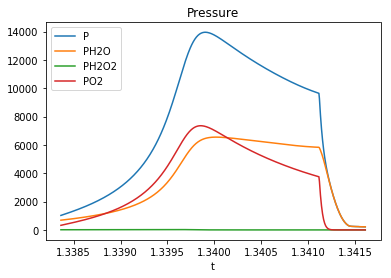

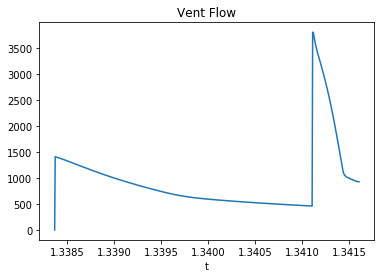

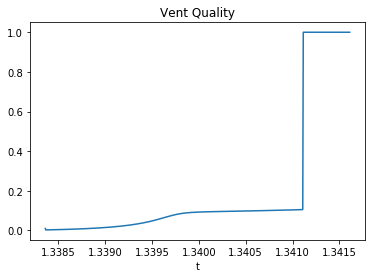

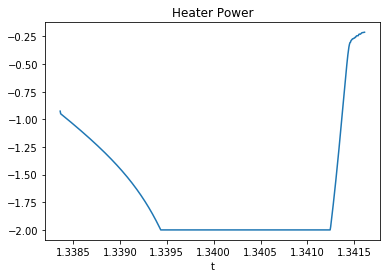

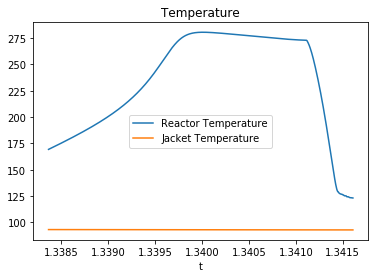

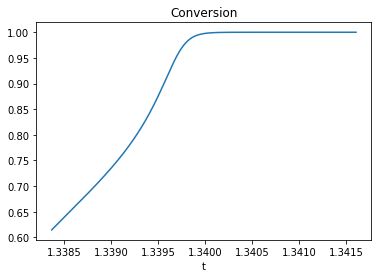

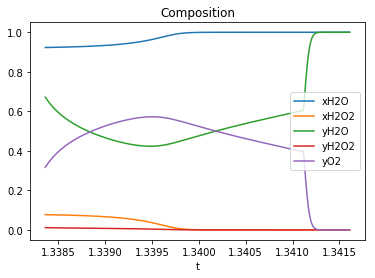

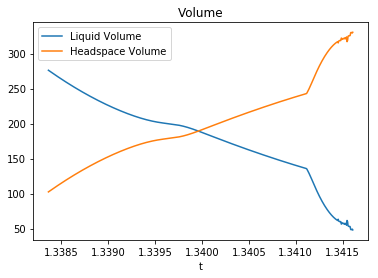

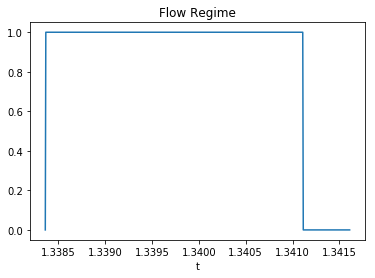

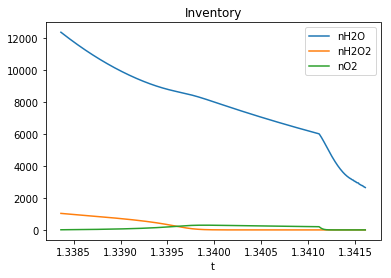

In [35]:
plt.figure(1)
plt.plot(t2[0:q]/(3600), data_vent[0:q,8], label = 'P')
plt.plot(t2[0:q]/(3600), data_vent[0:q,9], label = 'PH2O')
plt.plot(t2[0:q]/(3600), data_vent[0:q,10], label = 'PH2O2')
plt.plot(t2[0:q]/(3600), data_vent[0:q,11], label = 'PO2')
# plt.plot([t2[0], t2[q-1]/3600], [P_BPR, P_BPR], label = 'BPR Set Point')
# plt.axis([0, t[q-1]/3600, 100, 250])
plt.xlabel('t')
plt.legend()
plt.title('Pressure')

plt.figure(2)
plt.plot(t2[0:q]/(3600), n_RD[0:q], label = 'vent flow')
plt.xlabel('t')
plt.title('Vent Flow')

plt.figure(3)
plt.plot(t2[0:q]/(3600), xe[0:q], label = 'vent quality')
plt.xlabel('t')
plt.title('Vent Quality')
# plt.axis([t2[0]/3600, t2[q-1]/3600, 0, 1])

plt.figure(4)
plt.plot(t2[0:q]/(3600), rate_vent[0:q], label = 'heater power')
plt.xlabel('t')
plt.title('Heater Power')

plt.figure(5)
plt.plot(t2[0:q]/(3600), sol_vent[0:q,0], label = 'Reactor Temperature')
plt.plot(t2[0:q]/(3600), sol_vent[0:q,1], label = 'Jacket Temperature')
# plt.plot([t2[0], t2[q-1]/3600], [T_rxn, T_rxn], label = 'Set Point')
plt.xlabel('t')
plt.title('Temperature')
plt.legend()

plt.figure(6)
plt.plot(t2[0:q]/(3600), (sol[0, 3] - sol_vent[0:q, 3])/sol[0, 3], label = 'XH2O2')
# plt.axis([t2[0], t2[q-1]/3600, 0, 1])
plt.title('Conversion')
plt.xlabel('t')

plt.figure(7)
plt.plot(t2[0:q]/(3600), data_vent[0:q,0], label = 'xH2O')
plt.plot(t2[0:q]/(3600), data_vent[0:q,1], label = 'xH2O2')
plt.plot(t2[0:q]/(3600), data_vent[0:q,3], label = 'yH2O')
plt.plot(t2[0:q]/(3600), data_vent[0:q,4], label = 'yH2O2')
plt.plot(t2[0:q]/(3600), data_vent[0:q,5], label = 'yO2')
# plt.axis([t2[0], t2[q-1]/3600, 0, 1])
plt.xlabel('t')
plt.title('Composition')
plt.legend()

plt.figure(8)
plt.plot(t2[0:q]/(3600), data_vent[0:q,12], label = 'Liquid Volume')
plt.plot(t2[0:q]/(3600), data_vent[0:q,13], label = 'Headspace Volume')
# plt.axis([t2[0], t2[q-1]/3600, 0, VR])
plt.title('Volume')
plt.xlabel('t')
plt.legend()

plt.figure(9)
plt.plot(t2[0:q]/(3600), TF[0:q], label = 'Flow Regime')
plt.title('Flow Regime')
plt.xlabel('t')

plt.figure(11)
plt.plot(t2[0:q]/(3600), sol_vent[0:q,2], label = 'nH2O')
plt.plot(t2[0:q]/(3600), sol_vent[0:q,3], label = 'nH2O2')
plt.plot(t2[0:q]/(3600), sol_vent[0:q,4], label = 'nO2')
plt.xlabel('t')
plt.title('Inventory')
plt.legend()

In [ ]:
gt = 100
print(densityL(gt)) # Liquid density (kg/L)
print(antoine(gt)) # Saturation pressures for volatile components (kPa)

In [ ]:
#data_vent = xH2O, xH2O2, xO2, yH2O, yH2O2, yO2, nL, nG, P, PH2O, PH2O2, PO2, VL, VG, ZO2

plt.figure(1)
plt.plot(t[0:k]/(3600), data[0:k,8], label = 'P')
plt.plot(t[0:k]/(3600), data[0:k,9], label = 'PH2O')
plt.plot(t[0:k]/(3600), data[0:k,10], label = 'PH2O2')
plt.plot(t[0:k]/(3600), data[0:k,11], label = 'PO2')
plt.plot([0, t[k-1]/3600], [P_BPR, P_BPR], label = 'BPR Set Point')
# plt.axis([0, t[k-1]/3600, 100, 250])
plt.xlabel('t')
plt.legend()

plt.figure(2)
plt.plot(t[0:k]/(3600), n_vent[0:k], label = 'vent flow')
# plt.axis([0, t[k-1]/3600, 0, 0.02])
plt.xlabel('t')

plt.figure(3)
plt.plot(t[0:k]/(3600), P_critical[0:k], label = 'Critical Pressure')
plt.xlabel('t')

plt.figure(4)
plt.plot(t[0:k]/(3600), rate[0:k], label = 'heater power')
plt.xlabel('t')

plt.figure(5)
plt.plot(t[0:k]/(3600), sol[0:k,0], label = 'Reactor Temperature')
plt.plot(t[0:k]/(3600), sol[0:k,1], label = 'Jacket Temperature')
plt.plot([0, t[k-1]/3600], [T_rxn, T_rxn], label = 'Set Point')
plt.xlabel('t')
plt.legend()

plt.figure(6)
plt.plot(t[0:k]/(3600), (sol[0, 3] - sol[0:k, 3])/sol[0, 3], label = 'XH2O2')
plt.axis([0, t[k-1]/3600, 0, 1])
plt.xlabel('t')

plt.figure(7)
plt.plot(t[0:k]/(3600), data[0:k,0], label = 'xH2O')
plt.plot(t[0:k]/(3600), data[0:k,1], label = 'xH2O2')
plt.plot(t[0:k]/(3600), data[0:k,3], label = 'yH2O')
plt.plot(t[0:k]/(3600), data[0:k,4], label = 'yH2O2')
plt.plot(t[0:k]/(3600), data[0:k,5], label = 'yO2')
plt.axis([0, t[k-1]/3600, 0, 1])
plt.xlabel('t')
plt.legend()

plt.figure(8)
plt.plot(t[0:k]/(3600), data[0:k,12], label = 'Liquid Volume')
plt.plot(t[0:k]/(3600), data[0:k,13], label = 'Headspace Volume')
plt.axis([0, t[k-1]/3600, 0, VR])
plt.xlabel('t')
plt.legend()

plt.figure(9)
# plt.plot(t[0:k]/(3600), dsol[0:k,2], label = 'dnH2Odt')
plt.plot(t[0:k]/(3600), dsol[0:k,3], label = 'dnH2O2dt')
# plt.plot(t[0:k]/(3600), dsol[0:k,4], label = 'dnO2dt')
# plt.axis([0, t[k-1]/3600, -0.2, 0])
plt.xlabel('t')
plt.legend()

plt.figure(10)
plt.plot(t[0:k]/(3600), sol[0:k,2], label = 'nH2O')
plt.plot(t[0:k]/(3600), sol[0:k,3], label = 'nH2O2')
plt.plot(t[0:k]/(3600), sol[0:k,4], label = 'nO2')
plt.xlabel('t')
plt.legend()

## Optional csv Data Export

In [ ]:
# import csv
# csvfile = "dn.csv"

# #Assuming res is a flat list
# with open(csvfile, "w") as output:
#     writer = csv.writer(output, lineterminator='\n')
#     for val in dsol[0:k,3]:
#         writer.writerow([val])  

# csvfile2= "t.csv"

# #Assuming res is a flat list
# with open(csvfile2, "w") as output:
#     writer = csv.writer(output, lineterminator='\n')
#     for val in t:
#         writer.writerow([val]) 